In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
signaltrees = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])

In [4]:
signaltrees.extend(kwargs=lambda t:dict(n_presel_jet=t.n_jet))

[None]

In [5]:
subset = 'top8btag_signal'

event_filter = FilterSequence(
    CollectionFilter('jet', filter=lambda t: ak.argsort(ak.argsort(t.jet_btag,axis=-1,ascending=False)) < 8)
)

def has_higgs(t):
    jets = t.jet_signalId
    jets_idx = ak.local_index(jets, axis=-1)
    pairs = ak.unzip(ak.combinations(jets_idx, 2))
    j1_id, j2_id = jets[pairs[0]], jets[pairs[1]]
    diff = np.abs(j1_id - j2_id)
    add = j1_id + j2_id
    mod2 = add % 2
    paired = (diff*mod2 == 1) & ((add == 1) | (add == 5) | (add == 9) | (add == 13))
    
    signalId = ak.min(ak.concatenate([j1_id[:,:,None],j2_id[:,:,None]],axis=-1),axis=-1)//2
    signalId = ak.where(paired,signalId,-1)
    return ak.any(signalId>-1,axis=-1)

signal_filter = FilterSequence(
    event_filter,
    # EventFilter('at least one pair', filter=has_higgs)
    EventFilter('only signal bs',filter=lambda t:ak.sum(t.jet_signalId>-1,axis=-1)==8)
)

In [6]:
signaltrees = signaltrees.apply(signal_filter)

In [7]:
signaltrees.apply(build_all_dijets)

[None]

In [8]:
for tree in signaltrees: tree.color=None

In [9]:
varinfo.clear()

In [10]:
bkg_dijet_filter = CollectionFilter('dijet',filter=lambda t:t.dijet_signalId==-1)
sig_dijet_filter = CollectionFilter('dijet',filter=lambda t:t.dijet_signalId>-1)

treeiter = signaltrees.apply(bkg_dijet_filter) + signaltrees.apply(sig_dijet_filter)

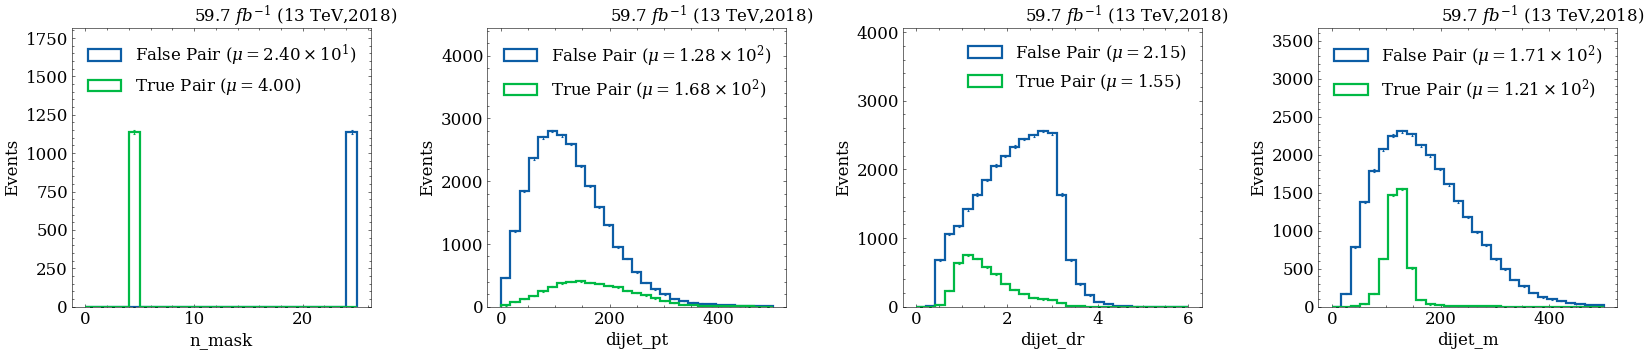

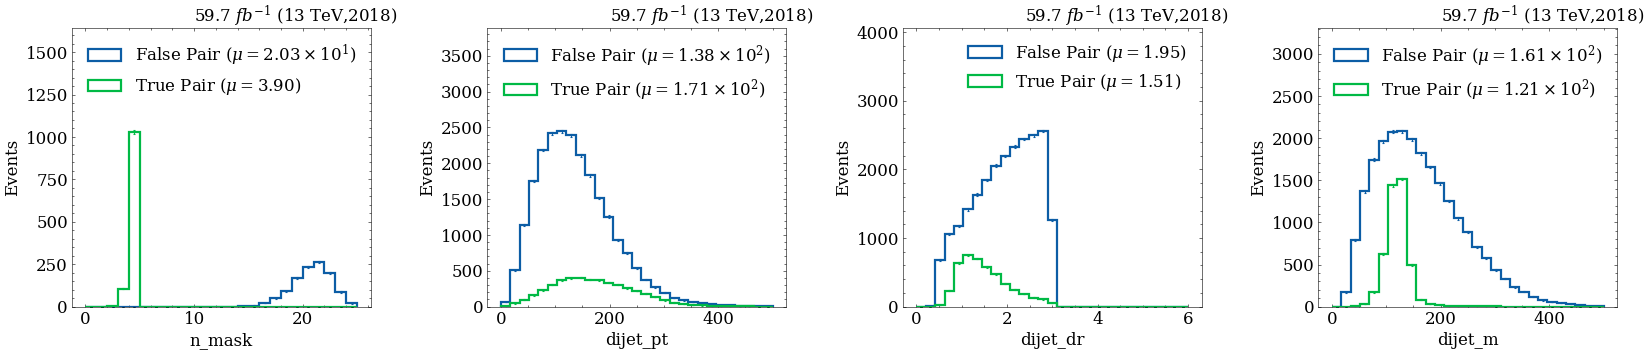

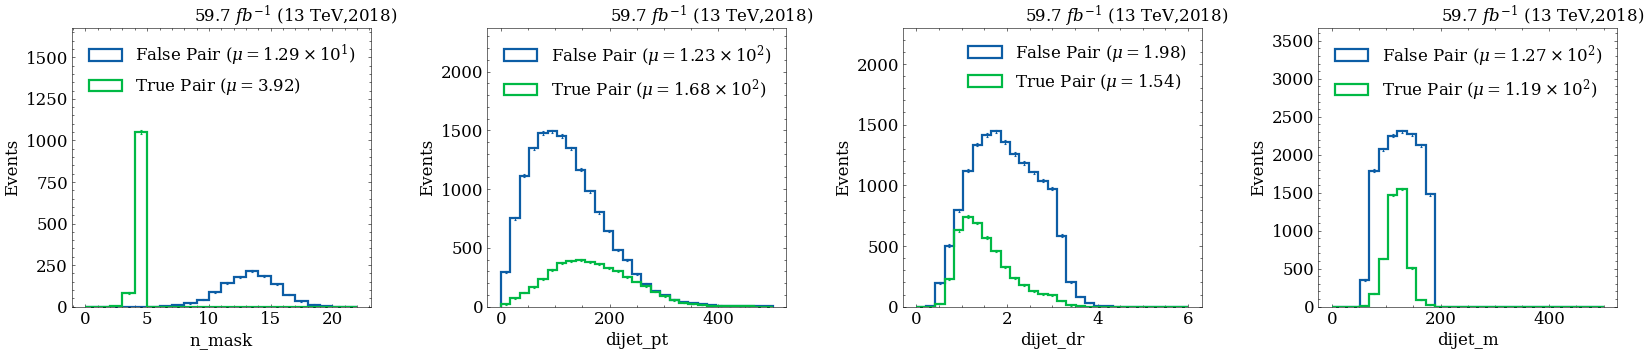

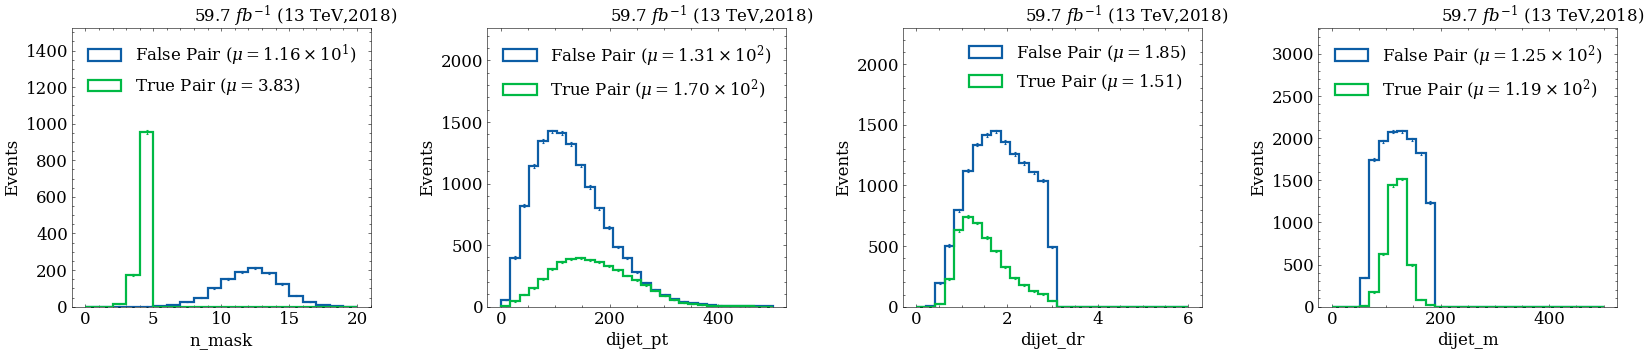

In [19]:
varlist=['n_mask','dijet_pt','dijet_dr','dijet_m']
kwargs=dict(
    varlist=varlist,
    binlist=[None,np.linspace(0,500,30),np.linspace(0,6,30),np.linspace(0,500,30)],
    dim=(-1,len(varlist)),
    label=['False Pair','True Pair'],
    legend=True, h_label_stat='mean'
)

study.quick(
    treeiter,
    masks=lambda t:ak.ones_like(t.dijet_pt)==1,
    **kwargs
)

study.quick(
    treeiter,
    masks=lambda t:t.dijet_dr<3,
    **kwargs
)

study.quick(
    treeiter,
    masks=lambda t:np.abs(t.dijet_m-125)<60,
    **kwargs
)

study.quick(
    treeiter,
    masks=lambda t:(t.dijet_dr<3)&(np.abs(t.dijet_m-125)<60),
    **kwargs
)

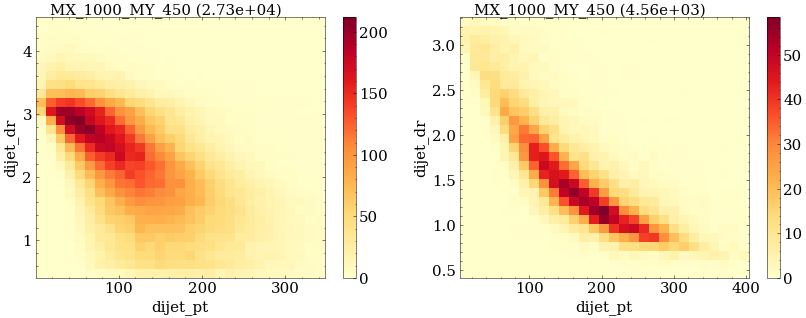

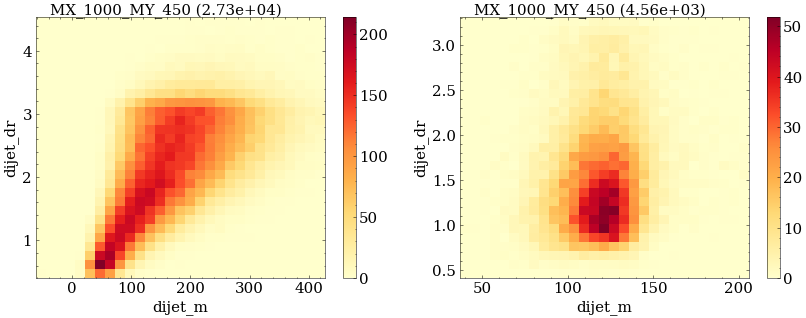

In [12]:
study.quick2d(
    treeiter,
    varlist=['dijet_pt','dijet_dr']
)

study.quick2d(
    treeiter,
    varlist=['dijet_m','dijet_dr']
)

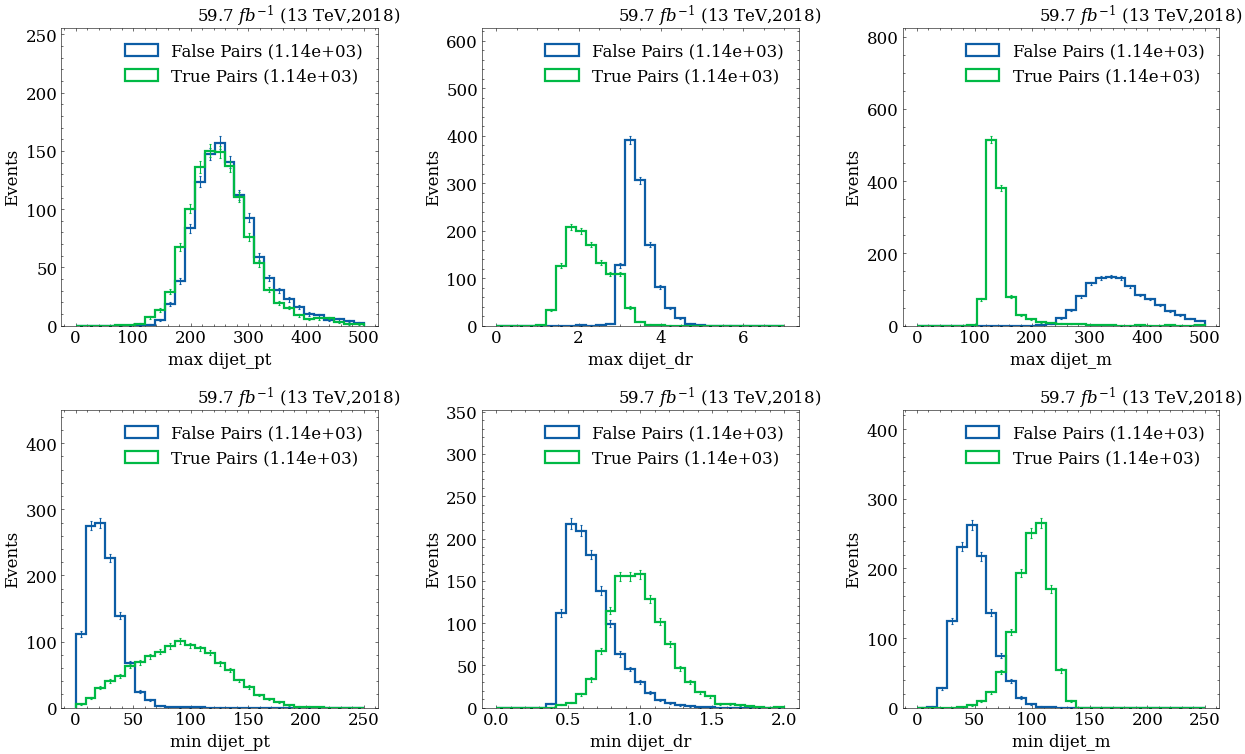

In [13]:
class var_max(ObjTransform):
    def __call__(self, t):
        return ak.max(t[self.var], axis=-1)
    def __str__(self):
        return f'max {self.var}'

class var_min(ObjTransform):
    def __call__(self, t):
        return ak.min(t[self.var], axis=-1)
    def __str__(self):
        return f'min {self.var}'

study.quick(
    treeiter,
    varlist=[var_max(var='dijet_pt'),var_max(var='dijet_dr'),var_max(var='dijet_m'),
             var_min(var='dijet_pt'),var_min(var='dijet_dr'),var_min(var='dijet_m')],
    binlist=[np.linspace(0,500,30),np.linspace(0,7,30),np.linspace(0,500,30),
             np.linspace(0,250,30),np.linspace(0,2,30),np.linspace(0,250,30)],
    label=['False Pairs','True Pairs'],
    legend=True,
    dim=(-1,3)
)

In [14]:
def max_dr_dijet_variables(tree):
    dijets = get_collection(tree,'dijet', False)
    idx = ak.argmax(dijets.dr,axis=-1)
    mask = get_jet_index_mask(dijets.pt, idx[:,None])

    max_dr_dijets = dijets[mask][:,0]
    tree.extend( rename_collection(max_dr_dijets,'max_dr_dijet') )

treeiter.apply(max_dr_dijet_variables)

[None, None]

In [15]:
treeiter.max_dr_dijet_dr

[<Array [4.01, 3.78, 3.51, ... 3.78, 3.38, 3.18] type='6357 * ?float64'>, <Array [2.19, 3.03, 2.74, ... 3.08, 2.77, 1.89] type='6357 * ?float64'>]

In [16]:
varinfo.max_dr_dijet_m = dict(bins=np.linspace(0,500,30))
varinfo.max_dr_dijet_pt = dict(bins=np.linspace(0,500,30))
varinfo.max_dr_dijet_dr = dict(bins=np.linspace(0,7,30))


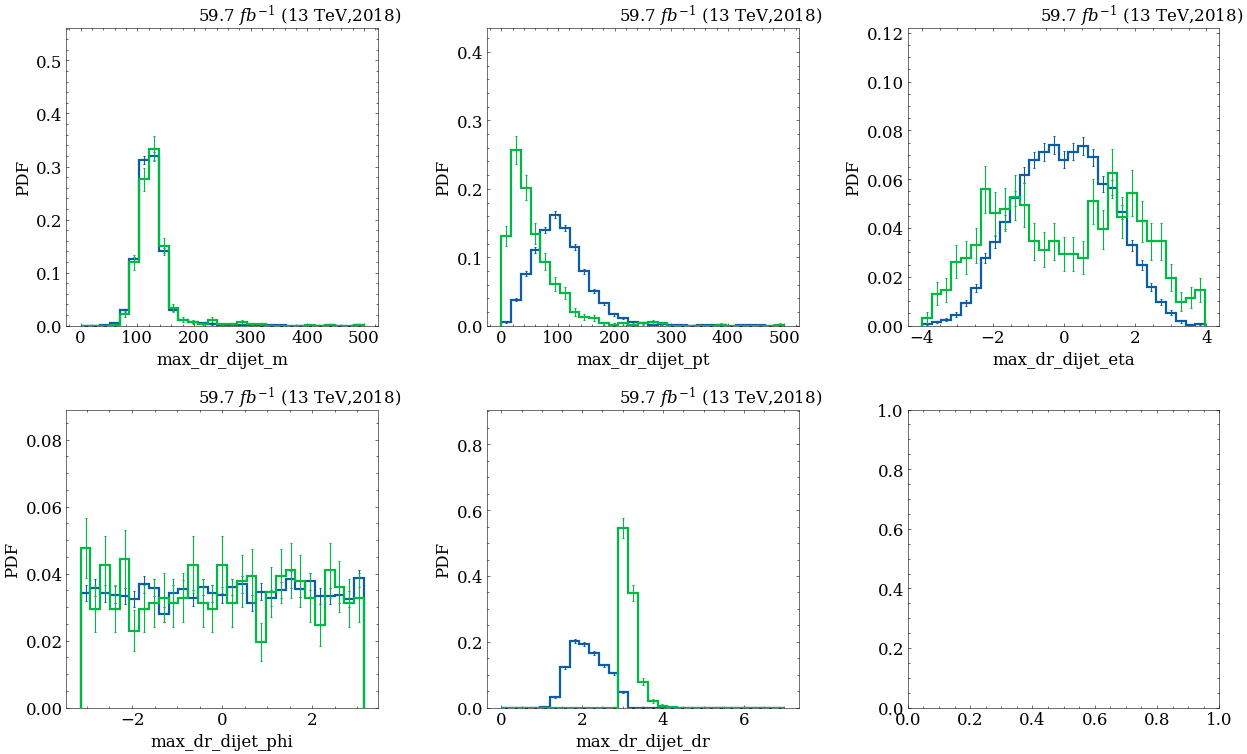

In [17]:
varlist = ['m','pt','eta','phi','dr']

study.quick(
    treeiter[[1,1]],
    masks=[lambda t:t.max_dr_dijet_dr<3,lambda t:t.max_dr_dijet_dr>3],
    varlist=[ f'max_dr_dijet_{var}' for var in varlist],
    # binlist=[np.linspace(0,7,30)]
    density=True,
    dim=(2,3)
)

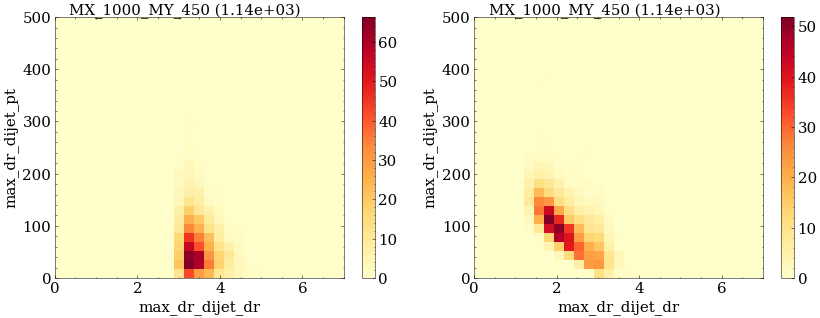

In [18]:
study.quick2d(
    treeiter,
    varlist=['max_dr_dijet_dr','max_dr_dijet_pt']
)